In [153]:
import pandas as pd
import pyodbc
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.rrule import rrule, MONTHLY
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import halfnorm
import shap
import numdifftools as nd
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
import pickle
shap.initjs()
%load_ext autoreload
%autoreload 2
import mmm_transformations
import mmm_preprocessing
import mmm_feature_selection
import mmm_modeling
import mmm_response_curves
import mmm_optimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [2]:
df_pp = pd.read_csv('insmed_hcp_month_multi_channel.csv')
df_pp

InsmedID     date  rx_count  P1_Arikayce  P2_Arikayce  \
0       INSP20000000  2022-01       0.0          0.0          0.0   
1       INSP20000000  2022-02       2.0          0.0          0.0   
2       INSP20000000  2022-03       0.0          0.0          0.0   
3       INSP20000000  2022-04       0.0          0.0          0.0   
4       INSP20000000  2022-05       1.0          0.0          0.0   
...              ...      ...       ...          ...          ...   
277555  INSP20136314  2022-08       0.0          0.0          0.0   
277556  INSP20136314  2022-09       0.0          0.0          0.0   
277557  INSP20136314  2022-10       0.0          0.0          0.0   
277558  INSP20136314  2022-11       0.0          0.0          0.0   
277559  INSP20136314  2022-12       0.0          0.0          0.0   

        sfmc_opened_email  publ_pulsepoint_count  deep_intent_count Specialty  \
0                     0.0                    0.0                0.0       PUD   
1                     0.0                    0.0                0.0       PUD   
2                     0.0                    0.0                0.0       PUD   
3                     0.0                    0.0                0.0       PUD   
4                     0.0                    0.0               57.0       PUD   
...                   ...                    ...                ...       ...   
277555                0.0                   10.0                0.0       PCC   
277556                0.0                   27.0                0.0       PCC   
277557                0.0                   28.0                0.0       PCC   
277558                0.0                   38.0                0.0       PCC   
277559                0.0                   15.0                0.0       PCC   

       PrimaryState  ...  Specialty_HOS Specialty_ID  Specialty_IM  \
0                VA  ...              0            0             0   
1                VA  ...              0            0             0   
2                VA  ...              0            0             0   
3                VA  ...              0            0             0   
4                VA  ...              0            0             0   
...             ...  ...            ...          ...           ...   
277555           MO  ...              0            0             0   
277556           MO  ...              0            0             0   
277557           MO  ...              0            0             0   
277558           MO  ...              0            0             0   
277559           MO  ...              0            0             0   

        Specialty_Other  Specialty_PCC  Specialty_PDP  Specialty_PUD  \
0                     0              0              0              1   
1                     0              0              0              1   
2                     0              0              0              1   
3                     0              0              0              1   
4                     0              0              0              1   
...                 ...            ...            ...            ...   
277555                0              1              0              0   
277556                0              1              0              0   
277557                0              1              0              0   
277558                0              1              0              0   
277559                0              1              0              0   

        Segment_Current Writer  Segment_Lapsed Writer  Segment_Non-Writer  
0                            0                      1                   0  
1                            0                      1                   0  
2                            0                      1                   0  
3                            0                      1                   0  
4                            0                      1                   0  
...                        ...                  

In [3]:
cols_to_keep = ['Specialty','date','rx_count', 'P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count',
               'deep_intent_count']
df_pp = df_pp[cols_to_keep].groupby(['Specialty', 'date']).sum().reset_index()
df_pp = pd.concat([df_pp, pd.get_dummies(df_pp[['Specialty']])], axis=1)
df_pp

Specialty     date  rx_count  P1_Arikayce  P2_Arikayce  sfmc_opened_email  \
0          AC  2022-01       1.0          2.0          1.0               15.0   
1          AC  2022-02       1.0          5.0          0.0               12.0   
2          AC  2022-03       0.0          1.0          1.0               11.0   
3          AC  2022-04       1.0          3.0          0.0               12.0   
4          AC  2022-05       0.0          2.0          1.0               16.0   
..        ...      ...       ...          ...          ...                ...   
151       PUD  2022-08      75.0        968.0         76.0               44.0   
152       PUD  2022-09      74.0        764.0         80.0              288.0   
153       PUD  2022-10      81.0        925.0         95.0              166.0   
154       PUD  2022-11      76.0        934.0        102.0              974.0   
155       PUD  2022-12      76.0        765.0         76.0             1410.0   

     publ_pulsepoint_count  deep_intent_count  Specialty_AC  Specialty_ADU  \
0                      0.0                0.0             1              0   
1                      0.0                0.0             1              0   
2                      0.0                0.0             1              0   
3                      0.0             1947.0             1              0   
4                      0.0             1992.0             1              0   
..                     ...                ...           ...            ...   
151                51050.0           250603.0             0              0   
152                96875.0           258453.0             0              0   
153                92413.0           237472.0             0              0   
154               201356.0                0.0             0              0   
155                77298.0                0.0             0              0   

     ...  Specialty_EM  Specialty_FM  Specialty_GP  Specialty_HOS  \
0    ...             0             0             0              0   
1    ...             0             0             0              0   
2    ...             0             0             0              0   
3    ...             0             0             0              0   
4    ...             0             0             0              0   
..   ...           ...           ...           ...            ...   
151  ...             0             0             0              0   
152  ...             0             0             0              0   
153  ...             0             0             0              0   
154  ...             0             0             0              0   
155  ...             0             0             0              0   

     Specialty_ID  Specialty_IM  Specialty_Other  Specialty_PCC  \
0               0             0                0              0   
1               0             0                0              0   
2               0             0                0              0   
3               0             0                0              0   
4               0             0                0              0   
..            ...           ...              ...            ...   
151             0             0                0              0   
152             0             0                0              0   
153             0             0                0              0   
154             0             0                0              0   
155             0             0                0              0   

     Specialty_PDP  Specialty_PUD  
0                0              0  
1                0              0  
2                0              0  
3                0              0  
4                0              0  
..             ...            ...  
151              0              1  
152              0              1  
153              0              1  
154              0              1  
155              0              1  

[156 rows x 21 columns]

# Transformations

In [4]:
transform = mmm_transformations.MMMTransformations()

In [5]:
df_t = transform.lag_dv(df_pp, 'rx_count', 3, 'Specialty')
df_t = transform.lag_dv(df_t, 'P1_Arikayce', 3, 'Specialty')
df_t = transform.lag_dv(df_t, 'P2_Arikayce', 3, 'Specialty')
df_t = transform.lag_dv(df_t, 'sfmc_opened_email', 3, 'Specialty')
df_t = transform.lag_dv(df_t, 'publ_pulsepoint_count', 3, 'Specialty')
df_t = transform.lag_dv(df_t, 'deep_intent_count', 3, 'Specialty')
df_t

Specialty     date  rx_count  P1_Arikayce  P2_Arikayce  sfmc_opened_email  \
0          AC  2022-01       1.0          2.0          1.0               15.0   
1          AC  2022-02       1.0          5.0          0.0               12.0   
2          AC  2022-03       0.0          1.0          1.0               11.0   
3          AC  2022-04       1.0          3.0          0.0               12.0   
4          AC  2022-05       0.0          2.0          1.0               16.0   
..        ...      ...       ...          ...          ...                ...   
151       PUD  2022-08      75.0        968.0         76.0               44.0   
152       PUD  2022-09      74.0        764.0         80.0              288.0   
153       PUD  2022-10      81.0        925.0         95.0              166.0   
154       PUD  2022-11      76.0        934.0        102.0              974.0   
155       PUD  2022-12      76.0        765.0         76.0             1410.0   

     publ_pulsepoint_count  deep_intent_count  Specialty_AC  Specialty_ADU  \
0                      0.0                0.0             1              0   
1                      0.0                0.0             1              0   
2                      0.0                0.0             1              0   
3                      0.0             1947.0             1              0   
4                      0.0             1992.0             1              0   
..                     ...                ...           ...            ...   
151                51050.0           250603.0             0              0   
152                96875.0           258453.0             0              0   
153                92413.0           237472.0             0              0   
154               201356.0                0.0             0              0   
155                77298.0                0.0             0              0   

     ...  P2_Arikayce_lag3  sfmc_opened_email_lag1  sfmc_opened_email_lag2  \
0    ...               0.0                     0.0                     0.0   
1    ...               0.0                    15.0                     0.0   
2    ...               0.0                    12.0                    15.0   
3    ...               1.0                    11.0                    12.0   
4    ...               0.0                    12.0                    11.0   
..   ...               ...                     ...                     ...   
151  ...              55.0                   919.0                    80.0   
152  ...              81.0                    44.0                   919.0   
153  ...              84.0                   288.0                    44.0   
154  ...              76.0                   166.0                   288.0   
155  ...              80.0                   974.0                   166.0   

     sfmc_opened_email_lag3  publ_pulsepoint_count_lag1  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                      15.0                         0.0   
4                      12.0                         0.0   
..                      ...                         ...   
151                  1049.0                     49065.0   
152                    80.0                     51050.0   
153                   919.0                     96875.0   
154                    44.0                     92413.0   
155                   288.0                    201356.0   

     publ_pulsepoint_count_lag2  publ_pulsepoint_count_lag3  \
0                           0.0                         0.0   
1                           0.0                         0.0   
2                           0.0                         0.0   
3                           0.0                         0.0   
4                           0.0                         0.0   
..                          ...                         ...   
151    

In [281]:
df_t[['Specialty', 'date', 'rx_count', 'P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']].to_csv('insmed_segment_month_multi_channel_bayesian_model.csv', index=False)

In [98]:
chk = df_t[['Specialty', 'rx_count', 'P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']]
chk.groupby('Specialty').agg({'rx_count': ['mean', 'max'], 'P1_Arikayce': ['mean', 'max'],
                             'P2_Arikayce': ['mean', 'max'], 'sfmc_opened_email': ['mean', 'max'],
                             'publ_pulsepoint_count': ['mean', 'max'], 'deep_intent_count': ['mean', 'max']}).reset_index()

Specialty    rx_count        P1_Arikayce        P2_Arikayce         \
                    mean    max        mean    max        mean    max   
0         AC    0.666667    2.0    2.333333    6.0    0.500000    1.0   
1        ADU    1.083333    3.0    5.750000   12.0    1.250000    3.0   
2        CCE    0.750000    2.0    4.416667    8.0    0.750000    2.0   
3         EM    0.083333    1.0    0.916667    4.0    0.000000    0.0   
4         FM    2.583333    6.0   19.666667   30.0    3.500000   10.0   
5         GP    3.583333   10.0   15.166667   26.0    0.833333    3.0   
6        HOS    0.500000    2.0    5.166667    9.0    0.083333    1.0   
7         ID  165.333333  180.0  555.416667  712.0   43.166667   61.0   
8         IM   15.916667   24.0  109.083333  167.0   17.250000   33.0   
9      Other   15.833333   23.0   67.250000   90.0    6.750000   10.0   
10       PCC    7.833333   14.0   54.666667   74.0    7.500000   12.0   
11       PDP    2.083333    7.0    0.750000    2.0    0.000000    0.0   
12       PUD   79.083333   94.0  718.000000  968.0   71.416667  102.0   

   sfmc_opened_email         publ_pulsepoint_count            \
                mean     max                  mean       max   
0           8.333333    16.0            398.416667    1912.0   
1          20.000000    43.0            562.583333    2720.0   
2           6.750000    13.0            403.250000    1692.0   
3         124.666667   243.0            404.250000    1746.0   
4         329.083333   606.0          11656.166667   51028.0   
5          69.500000   137.0           2432.083333   11098.0   
6          79.666667   176.0           2131.916667    8442.0   
7         461.833333   880.0          39615.833333  163206.0   
8         565.250000  1075.0          19395.833333   82558.0   
9         944.833333  1767.0          12808.500000   55378.0   
10         47.000000    83.0           2974.583333   12514.0   
11          0.416667     2.0            347.166667    1114.0   
12        770.333333  1410.0          47338.083333  201356.0   

   deep_intent_count            
                mean       max  
0        1314.833333    2450.0  
1        2302.333333    4842.0  
2        1644.916667    3448.0  
3        1073.416667    2850.0  
4       26977.333333   67250.0  
5        9360.666667   19419.0  
6        5341.833333   12879.0  
7      157453.416667  324384.0  
8       49987.333333  106614.0  
9       33659.083333   72878.0  
10       8929.583333   17290.0  
11        674.166667    6407.0  
12     140285.833333  264437.0

# Model Fitting

In [6]:
modeling = mmm_modeling.MMMModeling()

In [38]:
# modeling
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties]
#X = df_t[channels + lag_channels + specialties]
y = df_t['rx_count']
model = modeling.rf_regressor(df_t, X.columns.tolist(), 'rx_count', 'date')

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_modeling.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_modeling.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
pickle.dump(model, open('rf_insmed_multichannel_w_lagchannels_lag_dv.sav', 'wb'))

In [64]:
model = pickle.load(open('rf_insmed_multichannel_w_lagchannels_lag_dv.sav', 'rb'))

In [55]:
# performance
model['performance']

{'full': {'r2': 0.9938936051418544,
  'rmse': 3.61055663724712,
  'mape': 0.17547018987389515},
 'train': {'r2': 0.9954055454705126,
  'rmse': 3.1483871328763784,
  'mape': 0.17976291933805985},
 'test': {'r2': 0.9872283053131041,
  'rmse': 5.079551767020998,
  'mape': 0.8937121928547859}}

In [56]:
# importance
model['importance']

feature    importance       std
0                  P1_Arikayce  6.915886e-01  0.332010
30                Specialty_ID  1.056601e-01  0.222593
1                  P2_Arikayce  7.043422e-02  0.231261
35               Specialty_PUD  4.973125e-02  0.063314
20               rx_count_lag1  3.566194e-02  0.124478
5             P1_Arikayce_lag1  1.983894e-02  0.122517
21               rx_count_lag2  1.722227e-02  0.100719
2            sfmc_opened_email  2.045694e-03  0.011674
22               rx_count_lag3  1.565908e-03  0.008681
11      sfmc_opened_email_lag1  1.226188e-03  0.001213
12      sfmc_opened_email_lag2  6.380932e-04  0.000729
33               Specialty_PCC  5.620171e-04  0.000777
10            P2_Arikayce_lag3  5.447123e-04  0.001000
13      sfmc_opened_email_lag3  5.323574e-04  0.001202
4            deep_intent_count  4.082883e-04  0.000767
8             P2_Arikayce_lag1  3.825487e-04  0.000930
7             P1_Arikayce_lag3  3.339849e-04  0.000702
6             P1_Arikayce_lag2  3.095735e-04  0.001016
9             P2_Arikayce_lag2  3.052498e-04  0.000855
17      deep_intent_count_lag1  3.022334e-04  0.000497
19      deep_intent_count_lag3  1.792716e-04  0.000531
18      deep_intent_count_lag2  1.531171e-04  0.000283
3        publ_pulsepoint_count  9.993095e-05  0.000241
14  publ_pulsepoint_count_lag1  8.370251e-05  0.000291
16  publ_pulsepoint_count_lag3  6.884253e-05  0.000253
28                Specialty_GP  3.767822e-05  0.000125
15  publ_pulsepoint_count_lag2  2.494133e-05  0.000084
34               Specialty_PDP  2.388544e-05  0.000054
32             Specialty_Other  1.454819e-05  0.000109
31                Specialty_IM  1.165445e-05  0.000044
27                Specialty_FM  2.113884e-06  0.000007
23                Specialty_AC  1.847191e-06  0.000003
29               Specialty_HOS  1.712018e-06  0.000015
26                Specialty_EM  1.201221e-06  0.000004
24               Specialty_ADU  8.624182e-07  0.000004
25               Specialty_CCE  5.427086e-07  0.000002

In [57]:
# scatter plot of predictions
plot_df = pd.DataFrame({'date': model['df_preds_test']['date'].astype(str),
                        'preds': model['df_preds_test']['preds_test'],
                        'actual': model['df_preds_test']['rx_count']})
fig = px.scatter(plot_df, x="date", y=plot_df.columns.tolist(), title="Future Hold Out Set")
fig.show()

In [99]:
# scatter plot of predictions
plot_df = pd.DataFrame({'date': model['df_preds_full']['date'].astype(str),
                        'preds': model['df_preds_full']['preds_full'],
                        'actual': model['df_preds_full']['rx_count']})
fig = px.scatter(plot_df, x="date", y=plot_df.columns.tolist(), title="Random Forest - Model trained on full data")
fig.show()

In [101]:
model['df_preds_test']

Specialty     date  rx_count  P1_Arikayce  P2_Arikayce  sfmc_opened_email  \
10         AC  2022-11       1.0          1.0          0.0                9.0   
11         AC  2022-12       0.0          3.0          0.0               16.0   
22        ADU  2022-11       3.0          8.0          1.0               25.0   
23        ADU  2022-12       0.0          9.0          3.0               43.0   
34        CCE  2022-11       2.0          8.0          1.0                9.0   
35        CCE  2022-12       0.0          7.0          1.0                7.0   
46         EM  2022-11       0.0          3.0          0.0              139.0   
47         EM  2022-12       0.0          3.0          0.0              243.0   
58         FM  2022-11       3.0         28.0          7.0              389.0   
59         FM  2022-12       1.0         17.0          6.0              606.0   
70         GP  2022-11       2.0         16.0          1.0               81.0   
71         GP  2022-12       1.0         13.0          0.0              137.0   
82        HOS  2022-11       0.0          6.0          0.0               98.0   
83        HOS  2022-12       1.0          6.0          0.0              176.0   
94         ID  2022-11     176.0        689.0         53.0              587.0   
95         ID  2022-12     145.0        588.0         43.0              880.0   
106        IM  2022-11      15.0        142.0         14.0              695.0   
107        IM  2022-12      24.0        119.0         20.0             1075.0   
118     Other  2022-11      10.0         90.0          6.0             1180.0   
119     Other  2022-12      10.0         56.0          7.0             1767.0   
130       PCC  2022-11       6.0         64.0         12.0               59.0   
131       PCC  2022-12       7.0         66.0          7.0               83.0   
142       PDP  2022-11       2.0          1.0          0.0                0.0   
143       PDP  2022-12       1.0          2.0          0.0                0.0   
154       PUD  2022-11      76.0        934.0        102.0              974.0   
155       PUD  2022-12      76.0        765.0         76.0             1410.0   

     publ_pulsepoint_count  deep_intent_count  Specialty_AC  Specialty_ADU  \
10                  1912.0                0.0             1              0   
11                   801.0                0.0             1              0   
22                  2720.0                0.0             0              1   
23                  1214.0                0.0             0              1   
34                  1692.0                0.0             0              0   
35                   773.0                0.0             0              0   
46                  1746.0                0.0             0              0   
47                   848.0                0.0             0              0   
58                 51028.0                0.0             0              0   
59                 21134.0                0.0             0              0   
70                 11098.0                0.0             0              0   
71                  4891.0                0.0             0              0   
82                  8442.0                0.0             0              0   
83                  3510.0                0.0             0              0   
94                163206.0                0.0             0              0   
95                 65614.0                0.0             0              0   
106                82558.0                0.0             0              0   
107                33614.0                0.0             0              0   
118                55378.0                0.0             0              0   
119                22752.0                0.0             0              0   
130                12514.0                0.0             0              0   
131                 4948.0                0.0             0              0   
142                 11

In [13]:
model['df_preds_full'].corr()

rx_count  P1_Arikayce  P2_Arikayce  \
rx_count                    1.000000     0.840935     0.741465   
P1_Arikayce                 0.840935     1.000000     0.960738   
P2_Arikayce                 0.741465     0.960738     1.000000   
sfmc_opened_email           0.341939     0.397434     0.397517   
publ_pulsepoint_count       0.451415     0.647345     0.656370   
deep_intent_count           0.629968     0.671276     0.698707   
Specialty_AC               -0.137772    -0.147285    -0.149078   
Specialty_ADU              -0.135169    -0.143004    -0.139156   
Specialty_CCE              -0.137252    -0.144674    -0.145771   
Specialty_EM               -0.141417    -0.149060    -0.155692   
Specialty_FM               -0.125797    -0.125568    -0.109392   
Specialty_GP               -0.119549    -0.131206    -0.144668   
Specialty_HOS              -0.138813    -0.143735    -0.154590   
Specialty_ID                0.891034     0.545657     0.415349   
Specialty_IM               -0.042493    -0.013541     0.072504   
Specialty_Other            -0.043014    -0.065952    -0.066398   
Specialty_PCC              -0.092996    -0.081718    -0.056477   
Specialty_PDP              -0.128921    -0.149268    -0.155692   
Specialty_PUD               0.352160     0.749353     0.789062   
rx_count_lag1               0.929668     0.815598     0.728742   
rx_count_lag2               0.871127     0.786397     0.749312   
rx_count_lag3               0.809030     0.744707     0.708869   
P1_Arikayce_lag1            0.787340     0.943355     0.921629   
P1_Arikayce_lag2            0.740256     0.911031     0.924860   
P1_Arikayce_lag3            0.688696     0.860877     0.884722   
P2_Arikayce_lag1            0.691137     0.915989     0.927025   
P2_Arikayce_lag2            0.657603     0.886732     0.917216   
P2_Arikayce_lag3            0.612667     0.846351     0.888715   
sfmc_opened_email_lag1      0.337582     0.378347     0.368304   
sfmc_opened_email_lag2      0.288059     0.326524     0.406738   
sfmc_opened_email_lag3      0.274300     0.362775     0.440877   
publ_pulsepoint_count_lag1  0.393625     0.568820     0.552152   
publ_pulsepoint_count_lag2  0.390465     0.562361     0.553679   
publ_pulsepoint_count_lag3  0.332332     0.472154     0.466181   
deep_intent_count_lag1      0.642546     0.733375     0.753095   
deep_intent_count_lag2      0.632084     0.769744     0.776936   
deep_intent_count_lag3      0.567869     0.724933     0.711474   
preds_full                  0.998371     0.847384     0.750997   

                            sfmc_opened_email  publ_pulsepoint_count  \
rx_count                             0.341939               0.451415   
P1_Arikayce                          0.397434               0.647345   
P2_Arikayce                          0.397517               0.656370   
sfmc_opened_email                    1.000000               0.256823   
publ_pulsepoint_count                0.256823               1.000000   
deep_intent_count                    0.119150               0.331873   
Specialty_AC                        -0.183587              -0.108183   
Specialty_ADU                       -0.175198              -0.106477   
Specialty_CCE                       -0.184725              -0.108133   
Specialty_EM                        -0.099942              -0.108123   
Specialty_FM                         0.047035               0.008845   
Specialty_GP                        -0.139607              -0.087043   
Specialty_HOS                       -0.132297              -0.090163   
Specialty_ID                         0.142483               0.299497   
Specialty_IM                         0.216841               0.089302   
Specialty_Other                      0.489764               0.020824   
Specialty_PCC                       -0.155785              -0.081403   
Specialty_PDP                       -0.189279              -0.108716   
Specialty_PUD                        0.364297               0.379772   
rx_count_lag1

# Response Curves - Isolated Impact

In [12]:
response_curves = mmm_response_curves.MMMResponseCurves()

In [102]:
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties + ['Specialty', 'date']]
#X = df_t[channels + lag_channels + specialties + ['Specialty', 'date']]
#X[channels + lag_channels + specialties] = 0
#X[channels + lag_channels] = 0
p1_lags = [x for x in lag_channels if 'P1' in x]
p2_lags = [x for x in lag_channels if 'P2' in x]
email_lags = [x for x in lag_channels if 'email' in x]
pulse_lags = [x for x in lag_channels if 'pulse' in x]
deep_lags = [x for x in lag_channels if 'deep' in x]

In [27]:
df_t.describe()

rx_count  P1_Arikayce  P2_Arikayce  sfmc_opened_email  \
count  156.000000   156.000000   156.000000         156.000000   
mean    22.717949   119.891026    11.769231         263.666667   
std     46.353034   231.153003    21.892065         402.783834   
min      0.000000     0.000000     0.000000           0.000000   
25%      1.000000     3.000000     0.000000          10.000000   
50%      3.000000    12.500000     1.500000          69.500000   
75%     15.000000    71.750000    10.000000         384.500000   
max    180.000000   968.000000   102.000000        1767.000000   

       publ_pulsepoint_count  deep_intent_count  Specialty_AC  Specialty_ADU  \
count             156.000000         156.000000    156.000000     156.000000   
mean            10805.282051       33769.596154      0.076923       0.076923   
std             27858.986131       74310.032367      0.267328       0.267328   
min                 0.000000           0.000000      0.000000       0.000000   
25%                 0.000000           0.000000      0.000000       0.000000   
50%               102.500000        1969.500000      0.000000       0.000000   
75%              4261.750000       16749.250000      0.000000       0.000000   
max            201356.000000      324384.000000      1.000000       1.000000   

       Specialty_CCE  Specialty_EM  ...  P2_Arikayce_lag3  \
count     156.000000    156.000000  ...        156.000000   
mean        0.076923      0.076923  ...          8.160256   
std         0.267328      0.267328  ...         18.162172   
min         0.000000      0.000000  ...          0.000000   
25%         0.000000      0.000000  ...          0.000000   
50%         0.000000      0.000000  ...          0.000000   
75%         0.000000      0.000000  ...          5.250000   
max         1.000000      1.000000  ...         84.000000   

       sfmc_opened_email_lag1  sfmc_opened_email_lag2  sfmc_opened_email_lag3  \
count              156.000000              156.000000              156.000000   
mean               222.365385              195.153846              190.724359   
std                365.905101              351.632491              353.266190   
min                  0.000000                0.000000                0.000000   
25%                  3.750000                1.000000                0.000000   
50%                 36.000000               24.500000               18.000000   
75%                196.250000              150.750000              138.500000   
max               1616.000000             1616.000000             1616.000000   

       publ_pulsepoint_count_lag1  publ_pulsepoint_count_lag2  \
count                  156.000000                  156.000000   
mean                  9282.192308                 5469.602564   
std                  26956.754958                16337.387461   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
75%                   2284.750000                  712.500000   
max                 201356.000000                96875.000000   

       publ_pulsepoint_count_lag3  deep_intent_count_lag1  \
count                  156.000000              156.000000   
mean                  3758.538462            33769.596154   
std                  13269.753494            74310.032367   
min                      0.000000                0.000000   
25%                      0.000000                0.000000   
50%                      0.000000             1969.500000   
75%                     69.750000            16749.250000   
max                  96875.000000           324384.000000   

       deep_intent_count_lag2  deep_intent_count_lag3  
count              156.000000              156.000000  
mean             33769.596154            29046.179487  
std              74310.032367            69785.952497  
min                  0.000000                0.000000

In [93]:
df_t[['P1_Arikayce','P2_Arikayce']].sum().sum()

20539.0

In [66]:
# overall response curves
channel1 = response_curves.responses('overall', model['full_model'], X, 'P1_Arikayce', 1000, 5, 'Specialty', 'date', p1_lags)
channel2 = response_curves.responses('overall', model['full_model'], X, 'P2_Arikayce', 200, 1, 'Specialty', 'date', p2_lags)
channel3 = response_curves.responses('overall', model['full_model'], X, 'sfmc_opened_email', 2000, 10, 'Specialty', 'date', email_lags)
channel4 = response_curves.responses('overall', model['full_model'], X, 'publ_pulsepoint_count', 15000, 100, 'Specialty', 'date', pulse_lags)
channel5 = response_curves.responses('overall', model['full_model'], X, 'deep_intent_count', 35000, 100, 'Specialty', 'date', deep_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power



In [53]:
response_curves.plot(channel1['resp_df'], 'touches', ['P1_Arikayce', 'P1_Arikayce_hill_estimate'])

In [54]:
response_curves.plot(channel2['resp_df'], 'touches', ['P2_Arikayce', 'P2_Arikayce_hill_estimate'])

In [67]:
response_curves.plot(channel3['resp_df'], 'touches', ['sfmc_opened_email', 'sfmc_opened_email_hill_estimate'])

In [51]:
response_curves.plot(channel4['resp_df'], 'touches', ['publ_pulsepoint_count', 'publ_pulsepoint_count_hill_estimate'])

In [52]:
response_curves.plot(channel5['resp_df'], 'touches', ['deep_intent_count', 'deep_intent_count_hill_estimate'])

In [103]:
channel1_segment = response_curves.responses('segment', model['full_model'], X, 'P1_Arikayce', 1000, 5, 'Specialty', 'date', p1_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

In [125]:
channel1_segment['fig_raw']

In [105]:
channel1_segment['fig_hill']

In [106]:
channel2_segment = response_curves.responses('segment', model['full_model'], X, 'P2_Arikayce', 200, 1, 'Specialty', 'date', p2_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

In [107]:
channel2_segment['fig_raw']

In [108]:
channel2_segment['fig_hill']

In [109]:
channel3_segment = response_curves.responses('segment', model['full_model'], X, 'sfmc_opened_email', 2000, 10, 'Specialty', 'date', email_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

In [110]:
channel3_segment['fig_raw']

In [111]:
channel3_segment['fig_hill']

In [112]:
channel4_segment = response_curves.responses('segment', model['full_model'], X, 'publ_pulsepoint_count', 15000, 100, 'Specialty', 'date', pulse_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

In [113]:
channel4_segment['fig_raw']

In [114]:
channel4_segment['fig_hill']

In [115]:
channel5_segment = response_curves.responses('segment', model['full_model'], X, 'deep_intent_count', 35000, 100, 'Specialty', 'date', deep_lags)

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:122: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `fr

In [116]:
channel5_segment['fig_raw']

In [117]:
channel5_segment['fig_hill']

# Reponses - simulating segments as well

In [60]:
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties + ['Specialty']]
X[channels + lag_channels + specialties] = 0
p1_lags = [x for x in lag_channels if 'P1' in x]
p2_lags = [x for x in lag_channels if 'P2' in x]
email_lags = [x for x in lag_channels if 'email' in x]
pulse_lags = [x for x in lag_channels if 'pulse' in x]
deep_lags = [x for x in lag_channels if 'deep' in x]

channel1_segment_v2 = response_curves.responses_segment(model['full_model'], X, 'P1_Arikayce', 1000, 5, specialties, 'Specialty', p1_lags)
channel2_segment_v2 = response_curves.responses_segment(model['full_model'], X, 'P2_Arikayce', 200, 1, specialties, 'Specialty', p2_lags)
channel3_segment_v2 = response_curves.responses_segment(model['full_model'], X, 'sfmc_opened_email', 2000, 10, specialties, 'Specialty', email_lags)
channel4_segment_v2 = response_curves.responses_segment(model['full_model'], X, 'publ_pulsepoint_count', 15000, 100, specialties, 'Specialty', pulse_lags)
channel5_segment_v2 = response_curves.responses_segment(model['full_model'], X, 'deep_intent_count', 25000, 100, specialties, 'Specialty', deep_lags)

D:\Users\hartsingh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3645: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curv

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in power

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero encountered in reciprocal

D:\Users\hartsingh\Documents\Projects\commercial-analytics\promotion_response\research\mmm_response_curves.py:21: RuntimeWarning:

divide by zero

In [61]:
channel1_segment_v2['fig_raw']

In [62]:
channel2_segment_v2['fig_raw']

In [63]:
channel3_segment_v2['fig_raw']

In [65]:
channel4_segment_v2['fig_raw']

In [66]:
channel5_segment_v2['fig_raw']

# Shap

In [118]:
#Get SHAP interaction values
explainer = shap.TreeExplainer(model['full_model'])
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties]
shap_interaction = explainer.shap_interaction_values(X)

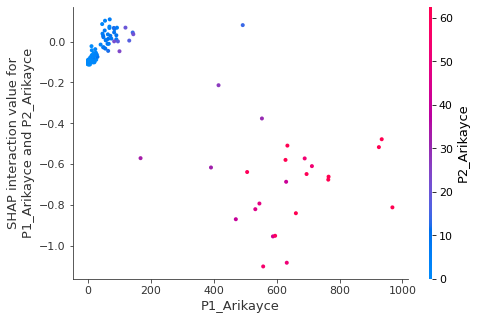

In [121]:
shap.dependence_plot(
    ("P1_Arikayce", "P2_Arikayce"),
    shap_interaction, X,
    display_features=X)

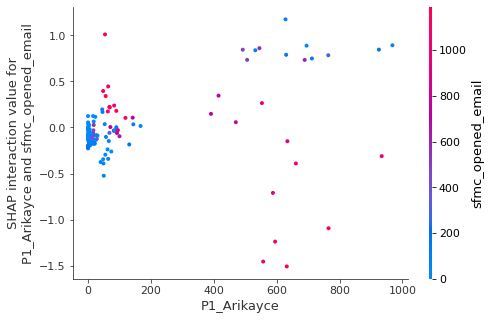

In [122]:
shap.dependence_plot(
    ("P1_Arikayce", "sfmc_opened_email"),
    shap_interaction, X,
    display_features=X)

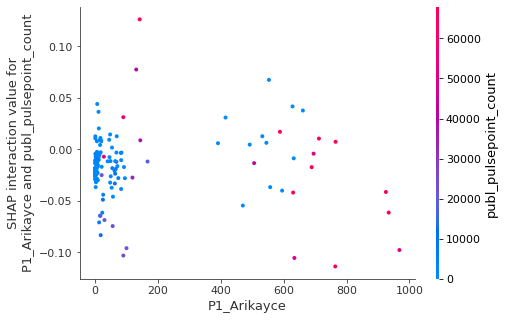

In [123]:
shap.dependence_plot(
    ("P1_Arikayce", "publ_pulsepoint_count"),
    shap_interaction, X,
    display_features=X)

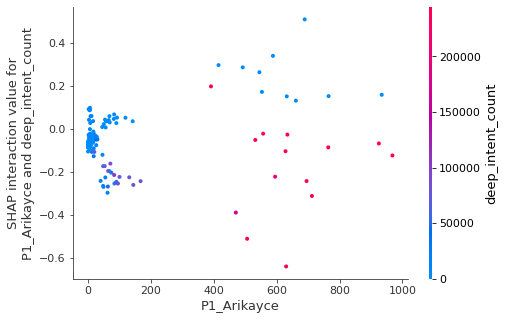

In [124]:
shap.dependence_plot(
    ("P1_Arikayce", "deep_intent_count"),
    shap_interaction, X,
    display_features=X)

# Budgeting Overall - Hill

In [83]:
overall_hill = pd.concat([pd.DataFrame(channel1['optimal_hill']).T, pd.DataFrame(channel2['optimal_hill']).T,
                         pd.DataFrame(channel3['optimal_hill']).T,pd.DataFrame(channel4['optimal_hill']).T,
                         pd.DataFrame(channel5['optimal_hill']).T])
overall_hill['feature'] = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
overall_hill.columns = ['beta', 'alpha', 'gamma', 'feature']
overall_hill

beta      alpha         gamma                feature
0   0.962494   0.275455  3.189146e+01            P1_Arikayce
0   0.991836   0.140809  9.817393e+00            P2_Arikayce
0  10.120613  19.025624  7.315834e-01      sfmc_opened_email
0   0.837760   2.055271  9.123839e-13  publ_pulsepoint_count
0   0.852862   0.368371  9.599313e+01      deep_intent_count

In [84]:
scalers = {'P1_Arikayce':{'x':channel1['scaler_x'], 'y':channel1['scaler_y']},
           'P2_Arikayce':{'x':channel2['scaler_x'], 'y':channel2['scaler_y']},
           'sfmc_opened_email':{'x':channel3['scaler_x'], 'y':channel3['scaler_y']},
           'publ_pulsepoint_count':{'x':channel4['scaler_x'], 'y':channel4['scaler_y']},
           'deep_intent_count':{'x':channel5['scaler_x'], 'y':channel5['scaler_y']}}

In [85]:
# overall response curves
config_dict = {'P1_Arikayce': {'max_tp': 1000, 'incr': 5},
               'P2_Arikayce': {'max_tp': 200, 'incr': 1},
               'sfmc_opened_email': {'max_tp': 2000, 'incr': 10},
               'publ_pulsepoint_count': {'max_tp': 15000, 'incr': 100},
               'deep_intent_count': {'max_tp': 35000, 'incr': 100}}

In [91]:
optimization = mmm_optimization.MMMOptimization(budget=10000, scalers=scalers)
output = optimization.optimize_hyperopt_hill(config_dict, 1000)
output

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.14trial/s, best loss: -109.64208653535819]


{'mix': {'P1_Arikayce': 85,
  'P2_Arikayce': 73,
  'deep_intent_count': 41,
  'publ_pulsepoint_count': 4,
  'sfmc_opened_email': 194},
 'trials': [{'loss': 99999989.19375195, 'status': 'ok'},
  {'loss': 99999996.99081011, 'status': 'ok'},
  {'loss': -31.91760383646744, 'status': 'ok'},
  {'loss': 99999989.41660613, 'status': 'ok'},
  {'loss': 99999989.40694882, 'status': 'ok'},
  {'loss': 99999889.62182936, 'status': 'ok'},
  {'loss': 99999988.89340785, 'status': 'ok'},
  {'loss': 99999889.14710341, 'status': 'ok'},
  {'loss': 99999889.91423935, 'status': 'ok'},
  {'loss': 99999989.48924111, 'status': 'ok'},
  {'loss': 99999889.37193815, 'status': 'ok'},
  {'loss': 99999989.53805001, 'status': 'ok'},
  {'loss': 99999889.48919798, 'status': 'ok'},
  {'loss': 99999889.38265005, 'status': 'ok'},
  {'loss': 99999896.8343103, 'status': 'ok'},
  {'loss': 99999889.3381386, 'status': 'ok'},
  {'loss': 99999889.30522409, 'status': 'ok'},
  {'loss': 99999889.65052646, 'status': 'ok'},
  {'loss':

In [87]:
overall_hill

beta      alpha         gamma                feature
0   0.962494   0.275455  3.189146e+01            P1_Arikayce
0   0.991836   0.140809  9.817393e+00            P2_Arikayce
0  10.120613  19.025624  7.315834e-01      sfmc_opened_email
0   0.837760   2.055271  9.123839e-13  publ_pulsepoint_count
0   0.852862   0.368371  9.599313e+01      deep_intent_count

In [89]:
budget = 10000
def objective(n):
    imp = float(scalers['P1_Arikayce']['y'].inverse_transform([[(0.962494 * (1 / (1 + (float(scalers['P1_Arikayce']['x'].transform(
                      [[n[0]]])) / 0.275455) ** (-3.189146e+01))))]])) + \
          float(scalers['P2_Arikayce']['y'].inverse_transform([[(0.991836 * (1 / (1 + (float(scalers['P2_Arikayce']['x'].transform(
                      [[n[1]]])) / 0.140809) ** (-9.817393))))]])) + \
          float(scalers['sfmc_opened_email']['y'].inverse_transform([[(10.120613 * (1 / (1 + (float(scalers['sfmc_opened_email']['x'].transform(
                      [[n[2]]])) / 19.025624) ** (-7.315834e-01))))]])) + \
          float(scalers['publ_pulsepoint_count']['y'].inverse_transform([[(0.837760 * (1 / (1 + (float(scalers['publ_pulsepoint_count']['x'].transform(
                      [[n[3]]])) / 2.0552716) ** (-9.123839e-13))))]])) + \
          float(scalers['deep_intent_count']['y'].inverse_transform([[(0.852862 * (1 / (1 + (float(scalers['deep_intent_count']['x'].transform(
                      [[n[4]]])) / 0.368371) ** (-9.599313e+01))))]]))
    return -1*imp
               
def constraint1(n):
    return budget - n[0] - n[1] - n[2] - n[3] -n[4]

b1 = (1,budget)
b2 = (1,budget)
b3 = (1,budget)
b4 = (1,budget)
b5 = (1,budget)
           
bnds= (b1,b2,b3,b4,b5)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [350,30,1200,1000,20000], bounds=bnds, constraints = cons)

print(sol)

     fun: -0.2946773444102283
     jac: array([ 0.        ,  0.        , -0.00042435,  0.        ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000000e+00, 1.00000000e+00, 4.66000486e+02, 2.65999757e+02,
       9.26599976e+03])


In [387]:
[[(0.6936530535197964 * (1 / (1 + (float(scalers['publ_pulsepoint_count']['x'].transform([[100]])) / 0.053966596517651996) ** (-26.943948734376008))))]]

2.345358215248263e-25

In [393]:
float(scalers['publ_pulsepoint_count']['y'].inverse_transform([[(0.6936530535197964 * (1 / (1 + (float(scalers['publ_pulsepoint_count']['x'].transform([[10000]])) / 0.053966596517651996) ** (-26.943948734376008))))]]))

0.07274464074092248

In [261]:
np.array([1,2,3]).astype(str).tolist()

['1', '2', '3']

In [286]:
chk = (0.9816892138809098*(1/(1+(0.475/0.2772247614816572)**(-28.264935056033174))))
float(scalers['P1_Arikayce']['y'].inverse_transform([[chk]]))

94.74255106435247

In [299]:
chk = (1.1444111790058762*(1/(1+(1.30313802e-01/0.4898744184231077)**(-3.5348516752558674))))
float(scalers['deep_intent_count']['y'].inverse_transform([[chk]]))

0.010940288646759666

In [292]:
channel1['resp_df'].head(50)

touches  P1_Arikayce  P1_Arikayce_hill_estimate  touches_scaled
0       0.0     0.000000               0.000000e+00           0.000
1       5.0     0.000000               4.857341e-48           0.005
2      10.0     0.167564               1.566722e-39           0.010
3      15.0     1.003782               1.486620e-34           0.015
4      20.0     1.261026               5.053417e-31           0.020
5      25.0     1.725385               2.771663e-28           0.025
6      30.0     1.701154               4.795050e-26           0.030
7      35.0     3.185705               3.741449e-24           0.035
8      40.0     8.141154               1.629966e-22           0.040
9      45.0     8.666731               4.549893e-21           0.045
10     50.0     9.346667               8.939921e-20           0.050
11     55.0    10.763590               1.322194e-18           0.055
12     60.0    10.700192               1.546630e-17           0.060
13     65.0    10.646090               1.485714e-16           0.065
14     70.0    11.140321               1.206794e-15           0.070
15     75.0    11.081474               8.482848e-15           0.075
16     80.0    11.118397               5.257408e-14           0.080
17     85.0    11.070705               2.917141e-13           0.085
18     90.0    11.093718               1.467555e-12           0.090
19     95.0    11.027756               6.765285e-12           0.095
20    100.0    11.027756               2.883546e-11           0.100
21    105.0    11.030000               1.145094e-10           0.105
22    110.0    11.030000               4.264700e-10           0.110
23    115.0    11.073269               1.498123e-09           0.115
24    120.0    11.071731               4.988612e-09           0.120
25    125.0    11.071731               1.581547e-08           0.125
26    130.0    11.071731               4.792128e-08           0.130
27    135.0    11.071731               1.392523e-07           0.135
28    140.0    11.071731               3.892480e-07           0.140
29    145.0    11.147885               1.049501e-06           0.145
30    150.0    11.147885               2.736119e-06           0.150
31    155.0    11.213013               6.912577e-06           0.155
32    160.0    11.206090               1.695762e-05           0.160
33    165.0    11.206090               4.046656e-05           0.165
34    170.0    11.206090               9.409148e-05           0.170
35    175.0    11.206090               2.134915e-04           0.175
36    180.0    11.206090               4.733534e-04           0.180
37    185.0    11.206090               1.026866e-03           0.185
38    190.0    11.206090               2.182073e-03           0.190
39    195.0    11.206090               4.546902e-03           0.195
40    200.0    11.206090               9.299885e-03           0.200
41    205.0    11.206090               1.868719e-02           0.205
42    210.0    11.204744               3.692029e-02           0.210
43    215.0    11.204744               7.177105e-02           0.215
44    220.0    11.204744               1.373573e-01           0.220
45    225.0    11.204744               2.589134e-01           0.225
46    230.0    11.204744               4.807633e-01           0.230
47    235.0    11.204744               8.791985e-01           0.235
48    240.0    11.204744               1.582192e+00           0.240
49    245.0    11.204744               2.796839e+00           0.245

In [265]:
chk

2.9598213326309354e-44

In [333]:
optimization = mmm_optimization.MMMOptimization(budget=250, params=overall_hill, scalers=scalers,
                                                x_scaler=scalers['deep_intent_count']['x'])
start_vals = [200, 35, 25, 25, 25]
output = optimization.optimize_hill(start_vals)
output

-1*((0.9816892138809098*(1/(1+(n[0]/0.2772247614816572)**(-28.264935056033174))))+(0.9500534186893317*(1/(1+(n[1]/0.12863511700657868)**(-24.117356560356065))))+(0.9877849737865367*(1/(1+(n[2]/0.33860186863341607)**(-7.020831073347136))))+(0.6936530535197964*(1/(1+(n[3]/0.053966596517651996)**(-26.943948734376008))))+(1.1444111790058762*(1/(1+(n[4]/0.4898744184231077)**(-3.5348516752558674)))))
[7.519749423196526, 0.18394988463930512, 1.0394988464171286, 7.7962413479478805, 13.025057680046494]
     fun: -3.5367276541224424e-11
     jac: array([ 0.00000000e+00,  0.00000000e+00, -1.20389809e-14,  0.00000000e+00,
       -1.25288401e-06])
 message: 'Optimization terminated successfully'
    nfev: 7
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.00751975, 0.00091975, 0.00051975, 0.00051975, 0.000521  ])


# Budgeting Channel 1 - Hill 

In [300]:
channel1_segment['optimal_hill']

{'AC_P1_Arikayce': array([ 0.98142001,  0.27654864, 26.44436982]),
 'ADU_P1_Arikayce': array([ 0.98143732,  0.27654873, 26.40320212]),
 'CCE_P1_Arikayce': array([ 0.98151879,  0.27646773, 26.17491963]),
 'EM_P1_Arikayce': array([ 0.98159362,  0.27639914, 25.96916239]),
 'FM_P1_Arikayce': array([ 0.98108205,  0.27686735, 27.3959862 ]),
 'GP_P1_Arikayce': array([ 0.9808304 ,  0.27707679, 28.09903593]),
 'HOS_P1_Arikayce': array([ 0.98151206,  0.27647197, 26.19411902]),
 'ID_P1_Arikayce': array([ 0.98212867,  0.2785834 , 36.23427618]),
 'IM_P1_Arikayce': array([ 0.98027873,  0.27757286, 29.45569421]),
 'Other_P1_Arikayce': array([ 0.98032566,  0.27750092, 29.06962426]),
 'PCC_P1_Arikayce': array([ 0.97957438,  0.27836405, 32.72697989]),
 'PDP_P1_Arikayce': array([ 0.98090965,  0.27698289, 27.86371678]),
 'PUD_P1_Arikayce': array([ 0.99435888,  0.2768009 , 19.53671378])}

In [316]:
channel1_segment['scaler_x']

{'AC_P1_Arikayce': MinMaxScaler(),
 'ADU_P1_Arikayce': MinMaxScaler(),
 'CCE_P1_Arikayce': MinMaxScaler(),
 'EM_P1_Arikayce': MinMaxScaler(),
 'FM_P1_Arikayce': MinMaxScaler(),
 'GP_P1_Arikayce': MinMaxScaler(),
 'HOS_P1_Arikayce': MinMaxScaler(),
 'ID_P1_Arikayce': MinMaxScaler(),
 'IM_P1_Arikayce': MinMaxScaler(),
 'Other_P1_Arikayce': MinMaxScaler(),
 'PCC_P1_Arikayce': MinMaxScaler(),
 'PDP_P1_Arikayce': MinMaxScaler(),
 'PUD_P1_Arikayce': MinMaxScaler()}

In [322]:
scalers = {'AC_P1_Arikayce':{'x':channel1_segment['scaler_x']['AC_P1_Arikayce'], 'y':channel1_segment['scaler_y']['AC_P1_Arikayce']},
           'ADU_P1_Arikayce':{'x':channel1_segment['scaler_x']['ADU_P1_Arikayce'], 'y':channel1_segment['scaler_y']['ADU_P1_Arikayce']},
           'CCE_P1_Arikayce':{'x':channel1_segment['scaler_x']['CCE_P1_Arikayce'], 'y':channel1_segment['scaler_y']['CCE_P1_Arikayce']},
           'EM_P1_Arikayce':{'x':channel1_segment['scaler_x']['EM_P1_Arikayce'], 'y':channel1_segment['scaler_y']['EM_P1_Arikayce']},
           'FM_P1_Arikayce':{'x':channel1_segment['scaler_x']['FM_P1_Arikayce'], 'y':channel1_segment['scaler_y']['FM_P1_Arikayce']},
           'GP_P1_Arikayce':{'x':channel1_segment['scaler_x']['GP_P1_Arikayce'], 'y':channel1_segment['scaler_y']['GP_P1_Arikayce']},
           'HOS_P1_Arikayce':{'x':channel1_segment['scaler_x']['HOS_P1_Arikayce'], 'y':channel1_segment['scaler_y']['HOS_P1_Arikayce']},
           'ID_P1_Arikayce':{'x':channel1_segment['scaler_x']['ID_P1_Arikayce'], 'y':channel1_segment['scaler_y']['ID_P1_Arikayce']},
           'IM_P1_Arikayce':{'x':channel1_segment['scaler_x']['IM_P1_Arikayce'], 'y':channel1_segment['scaler_y']['IM_P1_Arikayce']},
           'Other_P1_Arikayce':{'x':channel1_segment['scaler_x']['Other_P1_Arikayce'], 'y':channel1_segment['scaler_y']['Other_P1_Arikayce']},
           'PCC_P1_Arikayce':{'x':channel1_segment['scaler_x']['PCC_P1_Arikayce'], 'y':channel1_segment['scaler_y']['PCC_P1_Arikayce']},
           'PDP_P1_Arikayce':{'x':channel1_segment['scaler_x']['PDP_P1_Arikayce'], 'y':channel1_segment['scaler_y']['PDP_P1_Arikayce']},
           'PUD_P1_Arikayce':{'x':channel1_segment['scaler_x']['PUD_P1_Arikayce'], 'y':channel1_segment['scaler_y']['PUD_P1_Arikayce']}}

In [326]:
params = pd.DataFrame(channel1_segment['optimal_hill']).T
params.columns = ['beta','alpha','gamma']
optimization = mmm_optimization.MMMOptimization(budget=1000, params=params, scalers=scalers,
                                                x_scaler=scalers['AC_P1_Arikayce']['x'])
start_vals = [100]*13
output = optimization.optimize_hill(start_vals)
output

-1*((0.9814200058351079*(1/(1+(n[0]/0.27654863502851545)**(-26.444369815635604))))+(0.9814373151618*(1/(1+(n[1]/0.2765487284035332)**(-26.40320212067728))))+(0.9815187938980321*(1/(1+(n[2]/0.2764677288876743)**(-26.17491962711837))))+(0.9815936173814606*(1/(1+(n[3]/0.2763991414763619)**(-25.969162385459025))))+(0.9810820468236588*(1/(1+(n[4]/0.2768673509715969)**(-27.3959862045146))))+(0.9808304045542404*(1/(1+(n[5]/0.2770767891676555)**(-28.099035926924607))))+(0.9815120573177903*(1/(1+(n[6]/0.2764719697022465)**(-26.194119017093126))))+(0.9821286693484648*(1/(1+(n[7]/0.2785833962281289)**(-36.23427618060633))))+(0.9802787315097278*(1/(1+(n[8]/0.27757286071052845)**(-29.45569421453418))))+(0.9803256621860202*(1/(1+(n[9]/0.2775009165733722)**(-29.069624259770553))))+(0.979574380518687*(1/(1+(n[10]/0.27836404993694364)**(-32.72697989030838))))+(0.9809096487799662*(1/(1+(n[11]/0.2769828918186272)**(-27.86371677568481))))+(0.9943588754987306*(1/(1+(n[12]/0.27680090032251176)**(-19.5367137

# Budgeting Overall - Raw

In [86]:
optimization = mmm_optimization.MMMOptimization(budget=10000)
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties]
output = optimization.optimize_predict(X, channels, 1000, model['full_model'], 10)
output

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:18<00:00,  2.00trial/s, best loss: -113.32000000000001]


{'mix': {'P1_Arikayce': 100,
  'P2_Arikayce': 252,
  'deep_intent_count': 239,
  'publ_pulsepoint_count': 263,
  'sfmc_opened_email': 18},
 'trials': [{'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999886.06685898, 'status': 'ok'},
  {'loss': 99999885.67493589, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999899.61121795, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'loss': 99999887.98480769, 'status': 'ok'},
  {'l

In [200]:
optimization = mmm_optimization.MMMOptimization(budget=10000)
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
lag_dv = [x for x in df_t.columns if 'rx_count_lag' in x]
lag_channels = [x for x in df_t.columns if ('lag' in x) & ('rx_count' not in x)]
X = df_t[channels + lag_channels + lag_dv + specialties]
output2 = optimization.optimize_predict_segments(X, channels, specialties, 1000, model['full_model'], 10)
output2
# using this output do a cross tab of specialty and channels by summing up optimal number of touchpoints
# try also multiplying optimal

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:05<00:00,  1.83trial/s, best loss: -150.35448717948717]


{'mix': {'P1_Arikayce': 61,
  'P2_Arikayce': 258,
  'Specialty_AC': 1,
  'Specialty_ADU': 0,
  'Specialty_CCE': 0,
  'Specialty_EM': 0,
  'Specialty_FM': 0,
  'Specialty_GP': 0,
  'Specialty_HOS': 0,
  'Specialty_ID': 1,
  'Specialty_IM': 1,
  'Specialty_Other': 0,
  'Specialty_PCC': 0,
  'Specialty_PDP': 0,
  'Specialty_PUD': 0,
  'deep_intent_count': 88,
  'publ_pulsepoint_count': 299,
  'sfmc_opened_email': 6},
 'trials': [{'loss': 99999895.42076923, 'status': 'ok'},
  {'loss': 99999849.32961538, 'status': 'ok'},
  {'loss': 99999880.25461538, 'status': 'ok'},
  {'loss': 99999881.60666667, 'status': 'ok'},
  {'loss': 99999849.31935897, 'status': 'ok'},
  {'loss': 99999881.62064102, 'status': 'ok'},
  {'loss': 99999926.10903846, 'status': 'ok'},
  {'loss': 99999895.61602564, 'status': 'ok'},
  {'loss': 99999895.73397435, 'status': 'ok'},
  {'loss': 99999881.61365385, 'status': 'ok'},
  {'loss': 99999925.88057692, 'status': 'ok'},
  {'loss': 99999895.41788462, 'status': 'ok'},
  {'loss

In [256]:
optimization = mmm_optimization.MMMOptimization(budget=10000)
channels = ['P1_Arikayce', 'P2_Arikayce', 'sfmc_opened_email', 'publ_pulsepoint_count', 'deep_intent_count']
specialties = [x for x in df_spec_m.columns if x.startswith('Specialty_')]
lagged_channels = [x for x in df_spec_m.columns if 'lag' in x]
X = df_spec_m[channels + lagged_channels + specialties]
X[specialties] = 0
X['Specialty_ADU'] = 1
output = optimization.optimize_predict(X, channels, 1000, model2['full_model'], 10)
output

D:\Users\hartsingh\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3645: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\program files (x86)\python\python37-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:46<00:00,  1.90trial/s, best loss: -107.70564102564104]


{'mix': {'P1_Arikayce': 731,
  'P2_Arikayce': 4,
  'deep_intent_count': 223,
  'publ_pulsepoint_count': 360,
  'sfmc_opened_email': 76},
 'trials': [{'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -107.49820512820513, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -106.55846153846156, 'status': 'ok'},
  {'loss': -106.53916666666667, 'status': 'ok'},
  {'loss': -22.957435897435897, 'status': 'ok'},
  {'loss': -106.54980769230772, 'status': 'ok'},
  {'loss': -106.5391

In [ ]:
# takeaways
    # hcp month level data is too sparse to generate any meaningful insight and confidence in model results
    # segment, month level data yields strong and relatively fast results
    # shortening time frame to 1 year did not impact model performance
    # lag media channel variables removes need for adstocking
    # num of features > num rows becomes more of a concern for segment, month level data
    # calls have most impact followed by deep intent publisher and then emails, pulsepoint
    # digital can yield a higher impact on ADUs than emails
    # emails have no impact except a little on ADUs
    # simulating segments during response curves hardly change the story and just take longer
    # setting response cruves starting at 0
    
# troubleshooting
    # Segment level hyperopt mix
        # This should be trying to get interactions among channels within a specified specialty
        # But then how do we get optimal mix across segments within media channel
    # To include multiple segments we either need to build one hcp level model or segment level model one for each segment type
        # Problem with hcp level is data is too sparse
    # Response curves with interactions
    # NOT GETTING CONSISTENCY WITH OTHER CHANNELS - WHAT TO DO FOR POSTER?
    
# next steps
    # try this on meta data?
    # show current spend on charts
    # need cost information
    # optimal impact in isolation and using predict optimization and show difference in impacts
        # create a slide on this 
        # ideally mix with interaction will produce higher impact with same budget
        # update: with a budget of 250 touchpoints
            # predict optimization yield an impact of 26 rx per month per segment with only 217 touchpoints - 24% increase
            # isolation optimations would suggest max impactc of 21 rx per month 
    # to get segment level mix with interaction data should be each row is specialty and columns are media channels
    # to include more segments data for modeling should be segment1, segment2, date level - add additional segments into groupby
    
# questions 
    # do we even need isolation optimizer? Optimals can be found just by eyeballing 
    # what is the preferred methodology?
     # lag dv, lag media channels, or both
     # when generating response curves keep everything as is, zero out media only, zero out everything